In [ ]:
# Multi-Task Learning with Trainable Transformer + Improved Classifier
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Dataset for both tasks (with synthetic samples)
class TaskDataset(Dataset):
    def __init__(self, sentences, labels):
        self.sentences = sentences
        self.labels = labels

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        return self.sentences[idx], self.labels[idx]

In [ ]:
# Tokenizer and Transformer model
class TransformerEncoder(nn.Module):
    def __init__(self, model_name='bert-base-uncased'):
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.encoder = AutoModel.from_pretrained(model_name)

    def forward(self, sentences):
        tokens = self.tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
        outputs = self.encoder(**tokens)
        cls_embedding = outputs.last_hidden_state[:, 0]  # [CLS] token
        return cls_embedding

In [ ]:
# Multi-task model
class MultiTaskModel(nn.Module):
    def __init__(self, encoder, hidden_size=768, num_labels_a=3, num_labels_b=3):
        super().__init__()
        self.encoder = encoder
        self.classifier_a = nn.Sequential(
            nn.Dropout(0.3), nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.Linear(hidden_size, num_labels_a)
        )
        self.classifier_b = nn.Sequential(
            nn.Dropout(0.3), nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.Linear(hidden_size, num_labels_b)
        )

    def forward(self, sentences, task="A"):
        emb = self.encoder(sentences)
        return self.classifier_a(emb) if task == "A" else self.classifier_b(emb)

In [ ]:
# Sample synthetic data
sentences_a = ["Fetch Rewards helps me save.", "AI is transforming healthcare.", "The stock market rose."] * 20
labels_a = [0, 1, 2] * 20  # 3 classes

sentences_b = ["I love this app.", "The experience is okay.", "I dislike the rewards."] * 20
labels_b = [2, 1, 0] * 20  # sentiment: 0 - neg, 1 - neutral, 2 - pos

In [ ]:
# Split into train/dev
train_size = int(0.8 * len(sentences_a))
train_a = TaskDataset(sentences_a[:train_size], labels_a[:train_size])
dev_a = TaskDataset(sentences_a[train_size:], labels_a[train_size:])

train_b = TaskDataset(sentences_b[:train_size], labels_b[:train_size])
dev_b = TaskDataset(sentences_b[train_size:], labels_b[train_size:])

train_loader_a = DataLoader(train_a, batch_size=8, shuffle=True)
train_loader_b = DataLoader(train_b, batch_size=8, shuffle=True)
dev_loader_a = DataLoader(dev_a, batch_size=8)
dev_loader_b = DataLoader(dev_b, batch_size=8)

# Init model
encoder = TransformerEncoder("sentence-transformers/all-MiniLM-L6-v2")
model = MultiTaskModel(encoder, hidden_size=384)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)
criterion = nn.CrossEntropyLoss()

In [ ]:
import matplotlib.pyplot as plt

# Training loop with loss tracking
losses_a = []
losses_b = []

for epoch in range(5):
    model.train()
    print(f"\nEpoch {epoch+1}")

    epoch_loss_a = 0
    epoch_loss_b = 0
    steps = 0

    for step, ((sents_a, labels_a), (sents_b, labels_b)) in enumerate(zip(train_loader_a, train_loader_b)):
        out_a = model(sents_a, task="A")
        loss_a = criterion(out_a, labels_a)

        out_b = model(sents_b, task="B")
        loss_b = criterion(out_b, labels_b)

        total_loss = loss_a + loss_b
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        pred_a = torch.argmax(out_a, dim=1)
        pred_b = torch.argmax(out_b, dim=1)
        acc_a = accuracy_score(labels_a.numpy(), pred_a.detach().numpy())
        acc_b = accuracy_score(labels_b.numpy(), pred_b.detach().numpy())

        print(f"Step {step+1:02d} | Loss A: {loss_a.item():.4f} | Acc A: {acc_a:.2f} | Loss B: {loss_b.item():.4f} | Acc B: {acc_b:.2f}")

        epoch_loss_a += loss_a.item()
        epoch_loss_b += loss_b.item()
        steps += 1

    losses_a.append(epoch_loss_a / steps)
    losses_b.append(epoch_loss_b / steps)


Epoch 1
Step 01 | Loss A: 1.0604 | Acc A: 0.50 | Loss B: 1.0903 | Acc B: 0.25
Step 02 | Loss A: 1.0798 | Acc A: 0.62 | Loss B: 1.0784 | Acc B: 0.62
Step 03 | Loss A: 1.0468 | Acc A: 0.62 | Loss B: 1.0787 | Acc B: 0.50
Step 04 | Loss A: 0.9640 | Acc A: 0.75 | Loss B: 1.0804 | Acc B: 0.50
Step 05 | Loss A: 1.0188 | Acc A: 0.38 | Loss B: 1.0182 | Acc B: 0.62
Step 06 | Loss A: 0.9815 | Acc A: 1.00 | Loss B: 0.9689 | Acc B: 0.75

Epoch 2
Step 01 | Loss A: 0.9319 | Acc A: 1.00 | Loss B: 0.9971 | Acc B: 0.88
Step 02 | Loss A: 0.9088 | Acc A: 1.00 | Loss B: 0.9347 | Acc B: 1.00
Step 03 | Loss A: 0.8747 | Acc A: 1.00 | Loss B: 0.9529 | Acc B: 0.88
Step 04 | Loss A: 0.8088 | Acc A: 1.00 | Loss B: 0.8939 | Acc B: 1.00
Step 05 | Loss A: 0.8292 | Acc A: 1.00 | Loss B: 0.8759 | Acc B: 1.00
Step 06 | Loss A: 0.7673 | Acc A: 1.00 | Loss B: 0.8477 | Acc B: 1.00

Epoch 3
Step 01 | Loss A: 0.8030 | Acc A: 1.00 | Loss B: 0.8266 | Acc B: 1.00
Step 02 | Loss A: 0.7473 | Acc A: 1.00 | Loss B: 0.8211 | Acc B

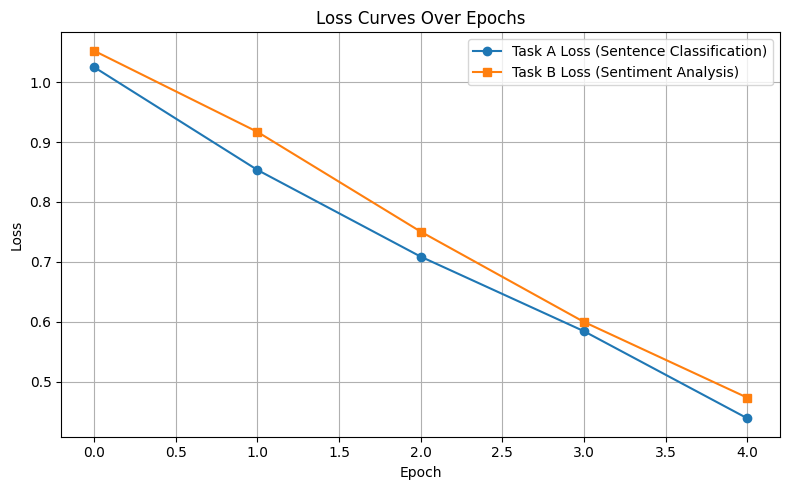

In [ ]:
# Plotting loss curves
plt.figure(figsize=(8, 5))
plt.plot(losses_a, label="Task A Loss (Sentence Classification)", marker='o')
plt.plot(losses_b, label="Task B Loss (Sentiment Analysis)", marker='s')
plt.title("Loss Curves Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Training loop
for epoch in range(5):
    model.train()
    for step, ((sents_a, labels_a), (sents_b, labels_b)) in enumerate(zip(train_loader_a, train_loader_b)):
        out_a = model(sents_a, task="A")
        loss_a = criterion(out_a, labels_a)

        out_b = model(sents_b, task="B")
        loss_b = criterion(out_b, labels_b)

        total_loss = loss_a + loss_b
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        pred_a = torch.argmax(out_a, dim=1)
        pred_b = torch.argmax(out_b, dim=1)
        acc_a = accuracy_score(labels_a.numpy(), pred_a.detach().numpy())
        acc_b = accuracy_score(labels_b.numpy(), pred_b.detach().numpy())

In [ ]:
# Evaluation on Dev Sets
model.eval()
y_true_a, y_pred_a = [], []
y_true_b, y_pred_b = [], []

with torch.no_grad():
    for sents, labels in dev_loader_a:
        outputs = model(sents, task="A")
        preds = torch.argmax(outputs, dim=1)
        y_true_a.extend(labels.tolist())
        y_pred_a.extend(preds.tolist())

    for sents, labels in dev_loader_b:
        outputs = model(sents, task="B")
        preds = torch.argmax(outputs, dim=1)
        y_true_b.extend(labels.tolist())
        y_pred_b.extend(preds.tolist())

In [ ]:
# Metrics for Task A (Classification)
print("\nClassification Report - Task A")
print("Accuracy:", accuracy_score(y_true_a, y_pred_a))
print("F1 Score:", f1_score(y_true_a, y_pred_a, average='macro'))


Classification Report - Task A
Accuracy: 1.0
F1 Score: 1.0


In [ ]:
# Metrics for Task B (Sentiment Analysis)
print("\nClassification Report - Task B")
print("Precision:", precision_score(y_true_b, y_pred_b, average='macro'))
print("Recall:", recall_score(y_true_b, y_pred_b, average='macro'))


Classification Report - Task B
Precision: 1.0
Recall: 1.0


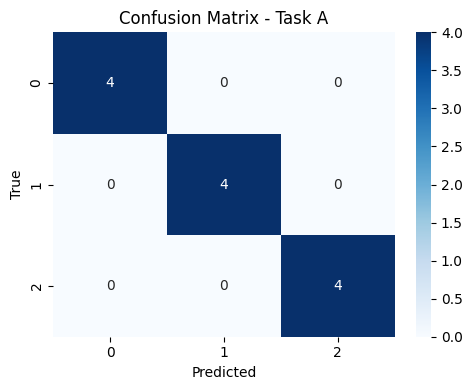

In [ ]:
# Confusion Matrix - Task A
cm_a = confusion_matrix(y_true_a, y_pred_a)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_a, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Task A")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

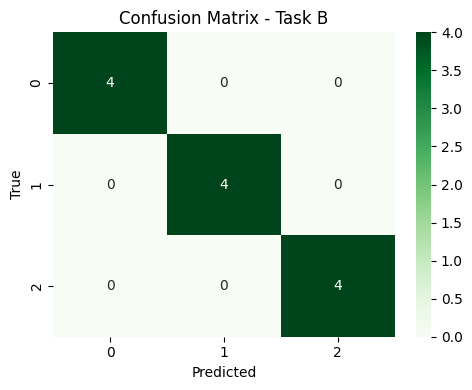

In [ ]:
# Confusion Matrix - Task B
cm_b = confusion_matrix(y_true_b, y_pred_b)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_b, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - Task B")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

## Final Takeaway: Why We Extended the Original Model

We **extend the original pretrained transformer model** to make it suitable for **multi-task learning** and **supervised classification tasks**.

### Specifically, we add:

1. **Encoder Wrapper**
   - Wraps the Hugging Face model (`AutoModel`) and tokenizer.
   - Handles:
     - Tokenization
     - Feeding data into the transformer
     - Extracting the `[CLS]` token (sentence-level embedding)

2. **Task-Specific Classifier Heads**
   - One head for each task (e.g., sentence classification, sentiment analysis)
   - Converts embeddings into logits for classification
   - Includes dropout and ReLU for improved generalization

---

### Without These Additions
- The transformer **only outputs embeddings**
- It **does not know** what labels or categories exist
- It **cannot be trained** on new classification tasks without a custom output layer


### With These Additions
- Enables the model to **learn and predict task-specific outputs**
- Supports **multi-task learning** with fine-tuning
- Allows per-task evaluation and metric tracking

### Architecture Comparison: Original vs. Multi-Task Enhanced

| **Aspect**                        | **Original Transformer**                          | **Updated Multi-Task Architecture**                               |
|----------------------------------|---------------------------------------------------|-------------------------------------------------------------------|
| **Model Type**                   | Pretrained Transformer (e.g., MiniLM/BERT)       | Transformer + Task-Specific Classifiers                          |
| **Input Handling**               | Tokenized text input                             | Tokenized text input + task identifier                           |
| **Encoder Output**               | Token embeddings or [CLS] token                   | Same, passed to downstream heads                                 |
| **Classifier Head**              | None                                           | Separate `nn.Sequential` heads per task (Task A & Task B)      |
| **Output**                       | Embeddings only (no prediction)                  | Logits for task-specific classes                                 |
| **Training Capability**          | Not directly trainable on classification tasks   | Fully trainable for each task                                    |
| **Support for Multi-Task**       | Not designed for MTL                           | Modular heads for each task (e.g., classification, sentiment)  |
| **Loss Functions**               | Not applicable                                 | Separate `CrossEntropyLoss` per task                           |
| **Evaluation Support**           | Manual                                          | Integrated: Accuracy, F1, Precision, Recall, Confusion Matrix |
| **Flexibility for New Tasks**    | Requires custom modifications                  | Plug-and-play new heads                                        |
